In [4]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


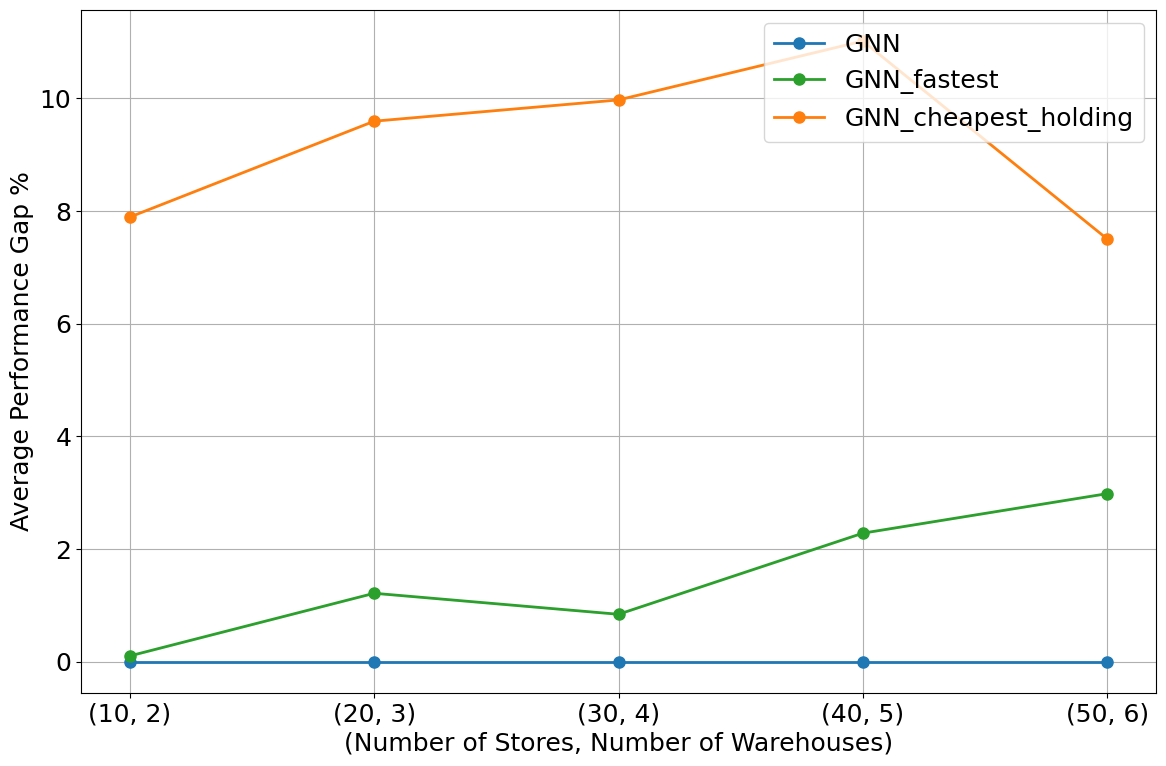

In [7]:
# Create vanilla results dataframe from the provided data
testset_name = "finals_n_warehouses_n_stores_no_edge_cost"

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme for architectures
color_scheme = {
    "GNN": "#1f77b4",          # Blue
    "GNN_fastest": "#2ca02c",   # Green  
    "GNN_cheapest_holding": "#ff7f0e",  # Orange
}

# Define paths for each architecture
architectures = {
    "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN',
    "GNN_fastest": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_fastest',
    "GNN_cheapest_holding": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_cheapest_holding',
}

# Define configs for different settings
configs = [
    "n_warehouse_10_2_lost_demand_no_edge_cost",
    "n_warehouse_20_3_lost_demand_no_edge_cost",
    "n_warehouse_30_4_lost_demand_no_edge_cost", 
    "n_warehouse_40_5_lost_demand_no_edge_cost", 
    "n_warehouse_50_6_lost_demand_no_edge_cost"
]

# Map configs to their (stores, warehouses) values for plotting
config_to_stores_warehouses = {
    "n_warehouse_10_2_lost_demand_no_edge_cost": (10, 2),
    "n_warehouse_20_3_lost_demand_no_edge_cost": (20, 3),
    "n_warehouse_30_4_lost_demand_no_edge_cost": (30, 4),
    "n_warehouse_40_5_lost_demand_no_edge_cost": (40, 5),
    "n_warehouse_50_6_lost_demand_no_edge_cost": (50, 6)
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
sample_size = 8192

dfs = []

# Create dataframes for each architecture and config
for arch_name, path in architectures.items():
    for config in configs:
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': [sample_size],
             'store_underage_cost': [9],
             'config': [config],
             'samples': [1]},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25)
        if df.empty:
            continue
        
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        df['train_dev_sample_and_batch_size'] = sample_size
        df['config'] = config
        df['n_stores'] = config_to_stores_warehouses[config][0]
        df['n_warehouses'] = config_to_stores_warehouses[config][1]
        dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Find best test loss for each config
best_losses = {}
for config in configs:
    config_data = df[df['config'] == config]
    if not config_data.empty:
        best_losses[config] = config_data['Test Loss'].min()

# Calculate performance gap percentage
stats_by_arch_and_config = {}
for config in configs:
    if config not in best_losses:
        continue
        
    best_loss = best_losses[config]
    config_data = df[df['config'] == config].copy()
    
    if config_data.empty:
        continue
        
    config_data.loc[:, 'Gap %'] = ((config_data['Test Loss'] - best_loss) / best_loss) * 100
    
    for arch in config_data['Architecture Class'].unique():
        key = arch
        if key not in stats_by_arch_and_config:
            stats_by_arch_and_config[key] = []
                
        arch_data = config_data[config_data['Architecture Class'] == arch]
        if not arch_data.empty:
            gaps = arch_data['Gap %'].to_numpy()
            mean_gap = np.mean(gaps)
            std_gap = np.std(gaps)
            ci_95 = 1.96 * std_gap / np.sqrt(len(gaps))
            stats_by_arch_and_config[key].append({
                'config': config,
                'n_stores': config_to_stores_warehouses[config][0],
                'n_warehouses': config_to_stores_warehouses[config][1],
                'mean_gap': mean_gap,
                'ci_lower': mean_gap - ci_95,
                'ci_upper': mean_gap + ci_95
            })

# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for arch, stats in stats_by_arch_and_config.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        # Sort by number of stores for proper x-axis ordering
        stats_df = stats_df.sort_values('n_stores')
        
        # Convert pandas series to numpy arrays before plotting
        n_stores_array = stats_df['n_stores'].to_numpy()
        mean_gap_array = stats_df['mean_gap'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(n_stores_array, mean_gap_array,
                color=color_scheme[arch],
                linestyle='-',
                linewidth=2,
                marker='o',
                markersize=8,
                label=arch)
        
        plt.fill_between(n_stores_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[arch],
                        alpha=0.1)

plt.xlabel('(Number of Stores, Number of Warehouses)', fontsize=FONTSIZE)
plt.ylabel('Average Performance Gap %', fontsize=FONTSIZE)
plt.grid(True)

# Create x-tick labels with (n_stores, n_warehouses) format
x_ticks = [10, 20, 30, 40, 50]
x_tick_labels = []
for n_stores in x_ticks:
    for config, (stores, warehouses) in config_to_stores_warehouses.items():
        if stores == n_stores:
            x_tick_labels.append(f"({stores}, {warehouses})")
            break

plt.xticks(x_ticks, x_tick_labels, fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

# Create legend
plt.legend(fontsize=FONTSIZE, loc='upper right')

plt.tight_layout()
plt.show()

In [8]:
df

,# of stores,hyperparam_name,train_dev_sample_and_batch_size,Architecture Class,store_underage_cost,config,samples,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,path,n_stores,n_warehouses
0,1,GNN,8192,GNN,9,n_warehouse_10_2_lost_demand_no_edge_cost,1,0.001,5.405661,5.423282,5.408033,3,/user/ml4723/Prj/NIC/ray_results/finals_n_ware...,10,2
1,1,GNN,8192,GNN,9,n_warehouse_20_3_lost_demand_no_edge_cost,1,0.001,5.673150,5.687581,5.678389,2,/user/ml4723/Prj/NIC/ray_results/finals_n_ware...,20,3
2,1,GNN,8192,GNN,9,n_warehouse_30_4_lost_demand_no_edge_cost,1,0.001,5.344685,5.337466,5.349531,2,/user/ml4723/Prj/NIC/ray_results/finals_n_ware...,30,4
3,1,GNN,8192,GNN,9,n_warehouse_40_5_lost_demand_no_edge_cost,1,0.001,5.270653,5.251412,5.249642,2,/user/ml4723/Prj/NIC/ray_results/finals_n_ware...,40,5
4,1,GNN,8192,GNN,9,n_warehouse_50_6_lost_demand_no_edge_cost,1,0.001,5.289049,5.276715,5.279106,3,/user/ml4723/Prj/NIC/ray_results/finals_n_ware...,50,6
5,1,GNN_fastest,8192,GNN_fastest,9,n_warehouse_10_2_lost_demand_no_edge_cost,1,0.001,5.406447,5.428290,5.413748,2,/user/ml4723/Prj/NIC/ray_results/finals_n_ware...,10,2
6,1,GNN_fastest,8192,GNN_fastest,9,n_warehouse_20_3_lost_demand_no_edge_cost,1,0.001,5.744268,5.757609,5.747477,2,/user/ml4723/Prj/NIC/ray_results/finals_n_ware...,20,3
7,1,GNN_fastest,8192,GNN_fastest,9,n_warehouse_30_4_lost_demand_no_edge_cost,1,0.001,5.389897,5.382596,5.394553,3,/user/ml4723/Prj/NIC/ray_results/finals_n_ware...,30,4
8,1,GNN_fastest,8192,GNN_fastest,9,n_warehouse_40_5_lost_demand_no_edge_cost,1,0.001,5.396816,5.371423,5.369414,3,/user/ml4723/Prj/NIC/ray_results/finals_n_ware...,40,5
9,1,GNN_fastest,8192,GNN_fastest,9,n_warehouse_50_6_lost_demand_no_edge_cost,1,0.001,5.444322,5.428122,5.431971,3,/user/ml4723/Prj/NIC/ray_results/finals_n_ware...,50,6
